# Samba Njie Research Thesis - Simulating Coupled Oscillators

**Goal:**


1. Can we generate a circadian oscillator given some parameters that determine coupling?

2. If we can, can the NeuralCDE framework use this to predict said parameters?

Answering the above questions enables us to validate the effectiveness of neural CDEs in

# Import Libraries

In [4]:
!pip install -U GPy jax diffrax mogptk tsgm tensorflow tensorflow_probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 17.8 MB/s eta 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ODE Solver from SciPy
from scipy.integrate import odeint

# NCDE
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import optax  # https://github.com/deepmind/optax

# For Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import GPy

# MOGPTK
import torch
import mogptk

# Sklearn periodic sinusoid
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

import pylab as pb

# simulate lotka-volterra like data
import tsgm

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.15; Detected an installation of version 2.13.1. Please upgrade TensorFlow to proceed.

# Generating Coupled Oscillators (Spring-Mass System)



## SciPy Example

**Source:** [SciPy](https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html)

In [7]:
def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, y1, x2, y2 = w
    m1, m2, k1, k2, L1, L2, b1, b2 = p

    # Create f = (x1',y1',x2',y2'):
    f = [y1,
         (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1,
         y2,
         (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2]
    return f

In [ ]:
# Use ODEINT to solve the differential equations defined by the vector field

# Parameter values
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants:
k1 = 8.0
k2 = 40.0
# Natural lengths:
L1 = 0.5
L2 = 1.0
# Friction coefficients:
b1 = 0.8
b2 = 0.5

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
x1 = 0.5
y1 = 0.0
x2 = 2.25
y2 = 0.0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 10.0
numpoints = 250

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Pack up the parameters and initial conditions:
p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [x1, y1, x2, y2]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

# with open('two_springs.dat', 'w') as f:
#     # Print & save the solution.
#     for t1, w1 in zip(t, wsol):

#         print(f"{f}, {t1}, {w1[0]}, {w1[1]}, {w1[2]}, {w1[3]}")

# Store data in pandas dataframe
sols = list()

for t1, w1 in zip(t, wsol):
  sols.append([f, t1, w1[0], w1[1], w1[2], w1[3]])

sols_df = pd.DataFrame(sols, columns = ["f", "t", "x1", "xy", "x2", "y2"])
sols_df.head()

<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.0, 0.5, 0.0, 2.25, 0.0
<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.040160642570281124, 0.5236970482198974, 1.1619709029830663, 2.234085829588334, -0.7836842047619311
<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.08032128514056225, 0.5909943513974764, 2.1501740668835443, 2.188299706157376, -1.4746893418634077
<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.12048192771084337, 0.6925535913875985, 2.8521026624259354, 2.117821422776064, -2.003176444793414
<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.1606425702811245, 0.8151946977409364, 3.1906321779335487, 2.030257220158287, -2.3192177284573523
<_io.TextIOWrapper name='two_springs.dat' mode='w' encoding='UTF-8'>, 0.20080321285140562, 0.9434897753595957, 3.131866591670441, 1.9347285508343177, -2.3979153508020596
<_io.TextIOWrapper name='two_springs.dat' mode='w' encod

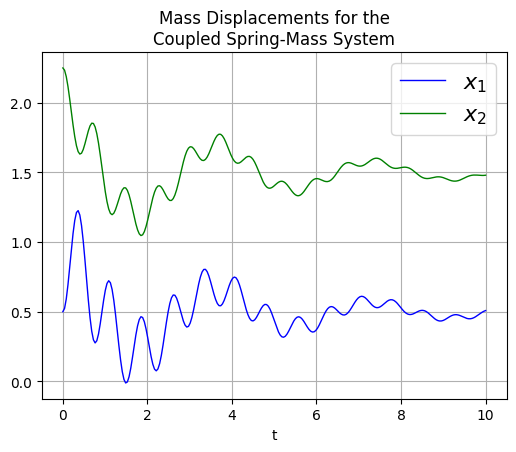

In [ ]:
# Plot the solution that was generated

from numpy import loadtxt
# from pylab import figure, plot, xlabel, grid, hold, legend, title, savefig
from matplotlib.font_manager import FontProperties

t, x1, xy, x2, y2 = sols_df.iloc[:, 1:].T.values

plt.figure(1, figsize=(6, 4.5))

plt.xlabel('t')
plt.grid(True)
# plt.hold(True)
lw = 1

plt.plot(t, x1, 'b', linewidth=lw)
plt.plot(t, x2, 'g', linewidth=lw)

plt.legend((r'$x_1$', r'$x_2$'), prop=FontProperties(size=16))
plt.title('Mass Displacements for the\nCoupled Spring-Mass System')
plt.savefig('two_springs.png', dpi=100)

## How to do it:

# Coupled Sinusoids Irregular Amplitudes

**Edit 11/14:** Many examples of coupled sinusoids start with defining the coupling constant in the differential equation system, not the solution thereof.

Hence to start at the solution, we may start by defining just a set of sinusoids that behave antagonistically, and look at the predictive power of the model as a proxy of how strong the coupling is.

## Simulate Data

In [ ]:
# Pg. 2: https://scholar.harvard.edu/files/schwartz/files/lecture3-coupled-oscillators.pdf

# Sinusoid definitions
def sin_sum(A_s, A_f, k, kappa, m, t, phi_s, phi_f):
  w_s = np.sqrt(k / m)
  w_f = np.sqrt((k + 2 * kappa) / m)
  return A_s * np.sin(w_s * t + phi_s) + A_f * np.sin(w_f * t + phi_f)

def sin_diff(A_s, A_f, k, kappa, m, t, phi_s, phi_f):
  w_s = np.sqrt(k / m)
  w_f = np.sqrt((k + 2 * kappa) / m)
  return A_s * np.sin(w_s * t + phi_s) - A_f * np.sin(w_f * t + phi_f)

# Sinusoidal params
A_s = 1
A_f = 1
k = 4
kappa = 2
m = 1
phi_s = 0
phi_f = 0

# Sampling params
n_obs = 1000
x_min = 0
x_max = 20

# Sample
x = np.linspace(x_min, x_max, n_obs)

# Apply
y_sum = sin_sum(A_s, A_f, k, kappa, m, x, phi_s, phi_f)
y_diff = sin_diff(A_s, A_f, k, kappa, m, x, phi_s, phi_f)


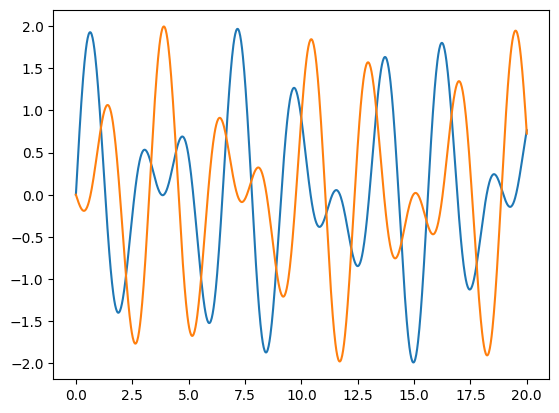

In [ ]:
plt.plot(x, y_sum)
plt.plot(x, y_diff)

In [ ]:
y_sum[:100]

array([ 0.00000000e+00,  9.66242541e-02,  1.93002924e-01,  2.88891108e-01,
        3.84045274e-01,  4.78223934e-01,  5.71188316e-01,  6.62703030e-01,
        7.52536724e-01,  8.40462721e-01,  9.26259652e-01,  1.00971207e+00,
        1.09061103e+00,  1.16875469e+00,  1.24394886e+00,  1.31600750e+00,
        1.38475328e+00,  1.45001802e+00,  1.51164318e+00,  1.56948026e+00,
        1.62339122e+00,  1.67324881e+00,  1.71893694e+00,  1.76035099e+00,
        1.79739804e+00,  1.82999712e+00,  1.85807942e+00,  1.88158846e+00,
        1.90048016e+00,  1.91472303e+00,  1.92429813e+00,  1.92919913e+00,
        1.92943231e+00,  1.92501646e+00,  1.91598281e+00,  1.90237493e+00,
        1.88424851e+00,  1.86167120e+00,  1.83472238e+00,  1.80349288e+00,
        1.76808468e+00,  1.72861059e+00,  1.68519390e+00,  1.63796794e+00,
        1.58707574e+00,  1.53266951e+00,  1.47491022e+00,  1.41396708e+00,
        1.35001704e+00,  1.28324424e+00,  1.21383943e+00,  1.14199947e+00,
        1.06792666e+00,  

### Structure VAR(p)

$$\begin{bmatrix} Y_{+, t} \\ Y_{-, t} \end{bmatrix} = \begin{bmatrix} \beta_{+, 0} \\ \beta_{-, 0} \end{bmatrix} + \begin{bmatrix} \beta_{+, t - 1} \\ \beta_{-, t - 1} \end{bmatrix}\begin{bmatrix} Y_{+, t - 1} \\ Y_{-, t - 1} \end{bmatrix} + \cdots + \begin{bmatrix} \beta_{+, t - p + 1} \\ \beta_{-, t - p + 1} \end{bmatrix}\begin{bmatrix} Y_{+, t - p + 1} \\ Y_{-, t - p + 1} \end{bmatrix}$$

[But this is the structure that NCDE takes](https://docs.google.com/drawings/d/1kf8yZwDAC331nqmuCCTZoBmoVBJ7nh6cZ8SvLgVXv3o/edit)

In [ ]:
ysum_lag.shape

(995, 5)

In [ ]:
# Suppose we have p auto-regressors
p = 5

ysum_lag = jnp.array([y_sum[k:k + p] for k in range(0, y_sum.shape[0] - p)])
ydiff_lag = jnp.array([y_diff[k:k + p] for k in range(0, y_diff.shape[0] - p)])

target_sum_lag = jnp.array([y_sum[k + p] for k in range(0, y_sum.shape[0] - p)]) # shape: (N, )
target_sum_lag = jnp.expand_dims(target_sum_lag, -1) # shape: (N, 1)
target_diff_lag = jnp.array([y_diff[k + p] for k in range(0, y_diff.shape[0] - p)])
target_diff_lag = jnp.expand_dims(target_diff_lag, -1)

# Shape (N, P). Data = [[0, 1, ..., P - 1], [1, 2, ..., P], ..., [N - P, ..., N]]
t_stack = jnp.array([list(range(n_obs))[k:k + p] for k in range(0, n_obs - p)])

# Stack X and y
y_feat_stack = jnp.stack([ysum_lag, ydiff_lag, t_stack], axis = -1)
y_target_stack = jnp.stack([target_sum_lag, target_diff_lag], axis = -1)

# Train test split
y_feat_train = y_feat_stack[:int(0.8 * n_obs)]
y_target_train = y_target_stack[:int(0.8 * n_obs)]

y_feat_test = y_feat_stack[int(0.8 * n_obs):]
y_target_test = y_target_stack[int(0.8 * n_obs):]
t_test = t_stack[int(0.8 * n_obs):]

# Do cubic spline interpolation to get X
coeffs_sim = jax.vmap(diffrax.backward_hermite_coefficients)\
  (t_stack, y_feat_stack)
coeffs_test = jax.vmap(diffrax.backward_hermite_coefficients)\
  (t_test, y_feat_test)

# Get configs from the time series
dataset_size, length, data_size = y_feat_stack.shape
dataset_size_train, length_train, data_size_train = y_feat_train.shape
dataset_size_test, length_test, data_size_test = y_feat_test.shape

In [ ]:
y_feat_test.shape

(195, 5, 3)

In [ ]:
t_stack

Array([[  0,   1,   2,   3,   4],
       [  1,   2,   3,   4,   5],
       [  2,   3,   4,   5,   6],
       ...,
       [992, 993, 994, 995, 996],
       [993, 994, 995, 996, 997],
       [994, 995, 996, 997, 998]], dtype=int32)

In [ ]:
jnp.expand_dims(target_sum_lag, -1).shape

(995, 1)

In [ ]:
t_stack.shape

(995, 5)

In [ ]:
y_sim_stack.shape

(995, 5, 3)

In [ ]:
y_target_stack.shape

(995, 1, 2)

## Setup NCDE

In [ ]:
# First, define the function which will specify the vector field of
# the differential equation.
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)

In [ ]:
# The above Func will be solved as part of the NeuralCDE algo
# Below. Note we do have an MLP for the initial condition
# As well as the future iterations.
# TODO: Modify this to output 3 values
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 2, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        )
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

In [ ]:
model_sim = NeuralCDE(data_size_train,
                      hidden_size,
                      width_size,
                      depth,
                      key=model_key)

In [ ]:
prediction_test = jax.vmap(model_sim)(t_test, coeffs_test)

ValueError: too many values to unpack (expected 1)

In [ ]:
prediction_test.shape

(195,)

# GPR

## Simulate Univariate Sinusoidal Data

In [ ]:
rng = np.random.default_rng(seed=42)
N = 200
T = 10

X = np.sort(rng.uniform(0, T, N))[:, np.newaxis]
y_noise_free = np.sin(X).ravel()
y_noisy = y_noise_free + rng.normal(0, 0.1, len(X))

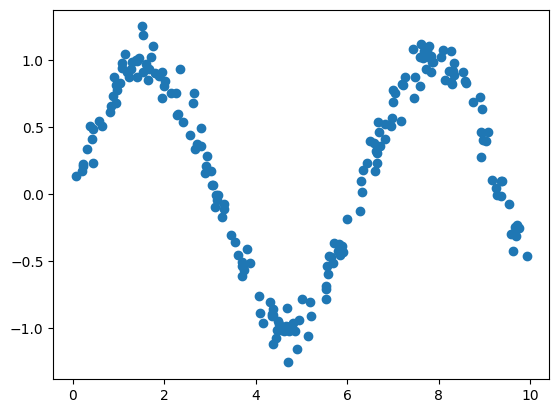

In [ ]:
plt.plot(X, y_noisy, 'o')

## GPR Modeling

### One Sinusoid

In [ ]:
kernel = 1.0 * RBF(length_scale=1.0)

gp_noise_free = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_noisy = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


In [ ]:
gp_noise_free.fit(X, y_noise_free)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [ ]:
# Step 6: Making Predictions
# Generate test data for evaluation
X_pred = np.linspace(0, 5, 1000)[:, np.newaxis]

# Predictions for noise-free model
y_pred_noise_free, sigma_noise_free = gp_noise_free.predict(X_pred, return_std=True)

# Predictions for noisy model
y_pred_noisy, sigma_noisy = gp_noisy.predict(X_pred, return_std=True)

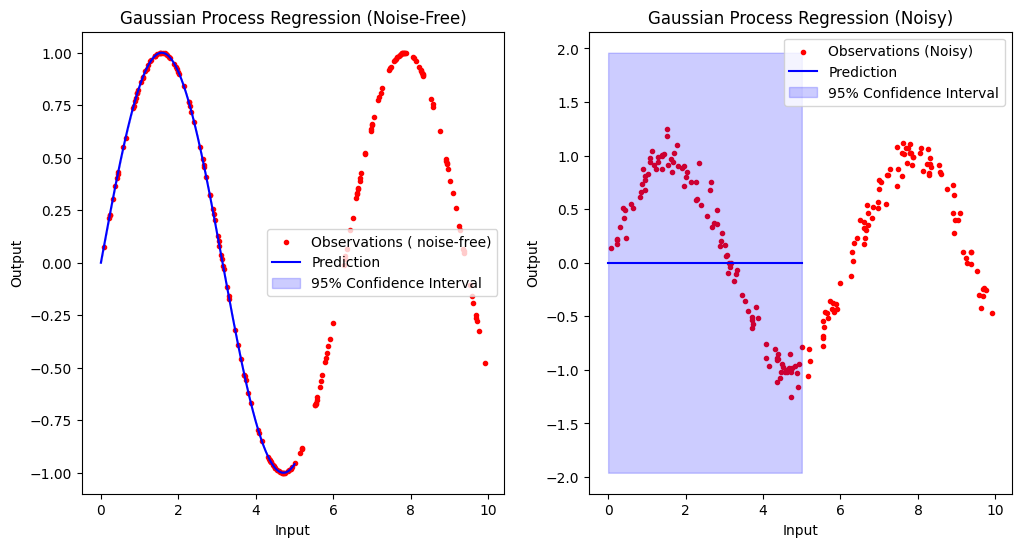

In [ ]:
# Step 7: Visualizing Regression Results
# Plotting noise-free results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X,
            y_noise_free,
            c='r', marker='.', label='Observations ( noise-free)')
plt.plot(X_pred,
         y_pred_noise_free,
         'b',
         label='Prediction')
plt.fill_between(X_pred.flatten(),
                 y_pred_noise_free - 1.96 * sigma_noise_free,
                 y_pred_noise_free + 1.96 * sigma_noise_free,
                 alpha=0.2,
                 color='blue',
                 label='95% Confidence Interval')
plt.title('Gaussian Process Regression (Noise-Free)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

# Plotting noisy results
plt.subplot(1, 2, 2)
plt.scatter(X,
            y_noisy,
            c='r',
            marker='.',
            label='Observations (Noisy)')
plt.plot(X_pred, y_pred_noisy, 'b', label='Prediction')
plt.fill_between(X_pred.flatten(),
                 y_pred_noisy - 1.96 * sigma_noisy,
                 y_pred_noisy + 1.96 * sigma_noisy,
                 alpha=0.2,
                 color='blue',
                 label='95% Confidence Interval')
plt.title('Gaussian Process Regression (Noisy)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

plt.show()

In [ ]:
gp_noise_free.kernel

1**2 * RBF(length_scale=1)

In [ ]:
gp_noise_free.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2,
 'kernel__k2': RBF(length_scale=1),
 'kernel__k1__constant_value': 1.0,
 'kernel__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2__length_scale': 1.0,
 'kernel__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel': 1**2 * RBF(length_scale=1),
 'n_restarts_optimizer': 10,
 'n_targets': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

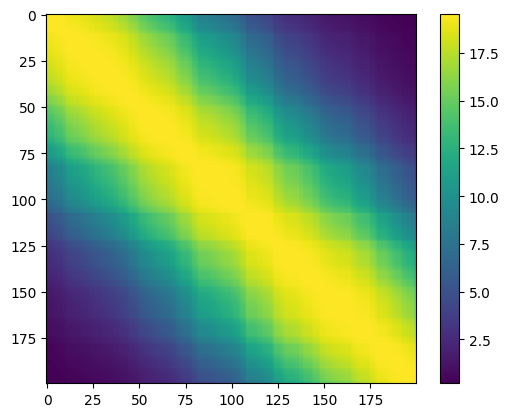

In [ ]:
opt_kernel_instance = gp_noise_free.kernel_
opt_kern_matrix = opt_kernel_instance(X = X)
plt.imshow(opt_kern_matrix)
plt.colorbar()

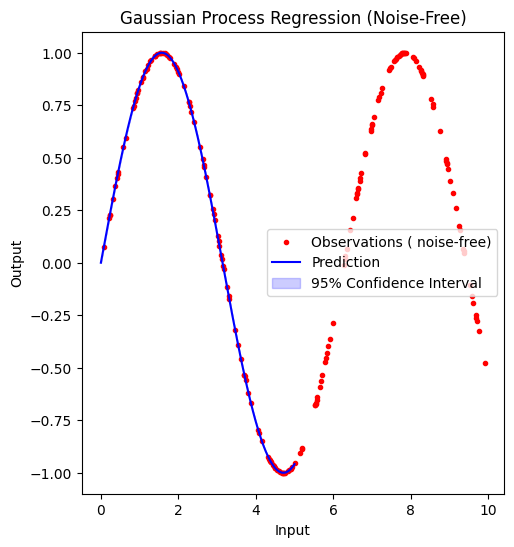

In [ ]:
kernel2 = 1.0 * RBF(length_scale=1.5)
X_pred2 = np.linspace(0, 5, 1000)[:, np.newaxis]
y_pred_noise_free2, sigma_noise_free2 = gp_noise_free.predict(X_pred2,
                                                              return_std=True)


# Step 7: Visualizing Regression Results
# Plotting noise-free results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X,
            y_noise_free,
            c='r', marker='.', label='Observations ( noise-free)')
plt.plot(X_pred2,
         y_pred_noise_free2,
         'b',
         label='Prediction')
plt.fill_between(X_pred2.flatten(),
                 y_pred_noise_free2 - 1.96 * sigma_noise_free2,
                 y_pred_noise_free2 + 1.96 * sigma_noise_free2,
                 alpha=0.2,
                 color='blue',
                 label='95% Confidence Interval')
plt.title('Gaussian Process Regression (Noise-Free)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()


### Two Sinusoids: Lotka-Volterra - Periodic Kernel using Scipy

In [ ]:
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

sns.set_style('darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Credit: https://peterroelants.github.io/posts/gaussian-process-kernels/
def periodic_tf(length_scale, period):
    """Periodic kernel TensorFlow operation."""
    amplitude_tf = tf.constant(1, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    period_tf = tf.constant(period, dtype=tf.float64)
    kernel = tfk.ExpSinSquared(
        amplitude=amplitude_tf,
        length_scale=length_scale_tf,
        period=period_tf)
    return kernel

def periodic(xa, xb, length_scale, period):
    """Evaluate periodic kernel."""
    kernel = periodic_tf(length_scale, period)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

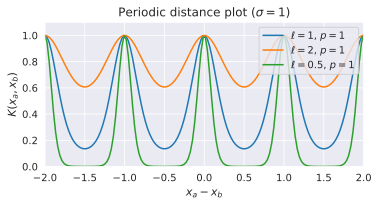

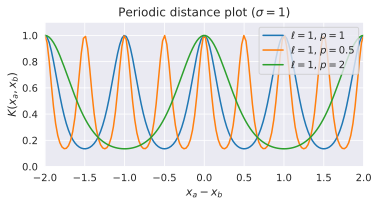

In [ ]:
# Plot periodic distance

xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=150), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=2., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=2$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=0.5, period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()


# Second plot
fig, ax = plt.subplots(figsize=(5.4,3))

Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=1$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=0.5$')
Σ = tfk.ExpSinSquared(amplitude=1., length_scale=1., period=2.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell=1$, $p=2$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

### Two Sinusoids: GPy

In [ ]:
d = 1
var = 1.
theta = 0.2
k = GPy.kern.RBF(d,var,theta)
# input dimension
# variance
# lengthscale

In [ ]:
# k = GPy.kern.RBF(d) # By default, the parameters are set to 1.
# theta = np.asarray([0.2,0.5,1.,2.,4.])
# for t in theta:
#     k['.*lengthscale']=t
#     k.plot()
# pb.legend(theta)

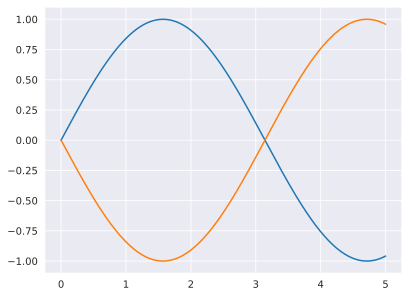

In [ ]:
X = np.linspace(0, 5, 1000)
X_2d = np.array([X, X])
Y1 = np.sin(X)
Y2 = -np.sin(X)
Y = np.array([Y1, Y2])

plt.plot(X, Y1)
plt.plot(X, Y2)

Code below does not work since periodic does not take multi-output.

In [ ]:
# kernel = GPy.kern.src.periodic.Periodic(
#     input_dim=2, variance=1, lengthscale=0.05,
#     period=6.28,
#     name='periodic',
#     n_freq=4,
#     lower=-1,
#     upper=1,
#     active_dims=[0]
# )

In [ ]:
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)


In [ ]:
Y.T.shape

(1000, 2)

In [ ]:
m = GPy.models.GPRegression(X_2d,Y.T,kernel)

ValueError: failed in converting 2nd argument `b' of _flapack.dpotrs to C/Fortran array

## MOGPTK : Multi-Output Gaussian Process Toolkit

+ [Github](https://github.com/GAMES-UChile/mogptk)

### Two Antagonistic Sinusoids

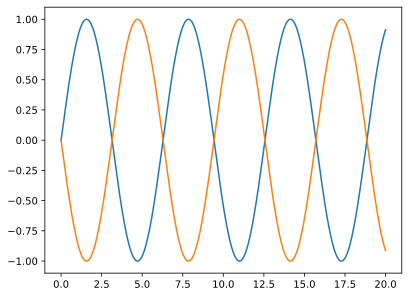

In [ ]:
t = np.linspace(0, 20, 1000)
t_2d = np.array([t, t])
y1 = np.sin(t)
y2 = -np.sin(t)
y = np.array([y1, y2])

plt.plot(t, y1)
plt.plot(t, y2)

In [ ]:
# create dataset
dataset = mogptk.DataSet(
    mogptk.Data(t, y1, name='First channel'),
    mogptk.Data(t, y2, name='Second channel'),
)

# remove a future set of data from each sinusoid
dataset[0].remove_range(start = 12.0)
dataset[1].remove_range(start = 12.0)

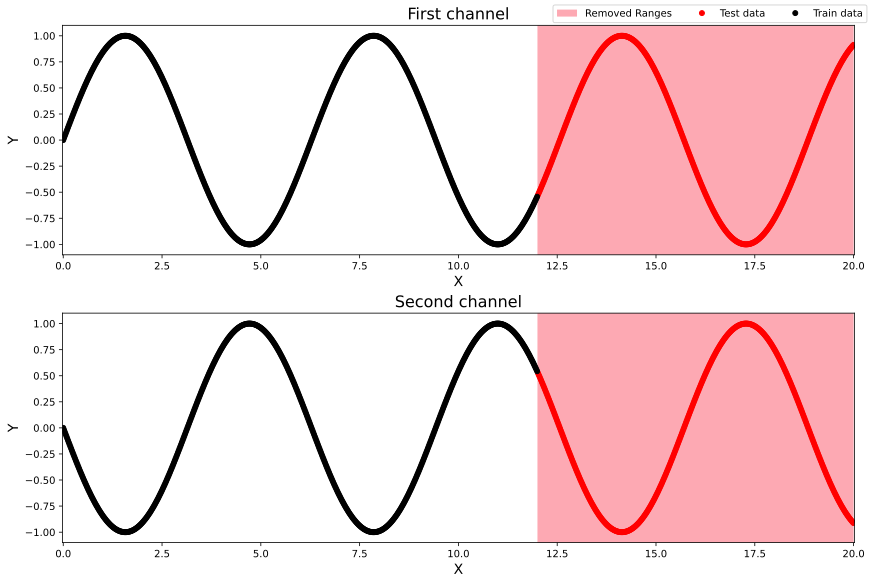

In [ ]:
dataset.plot();

In [ ]:
# create model, uncomment for different kernels
model = mogptk.MOSM(dataset, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SM_LMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.print_parameters()


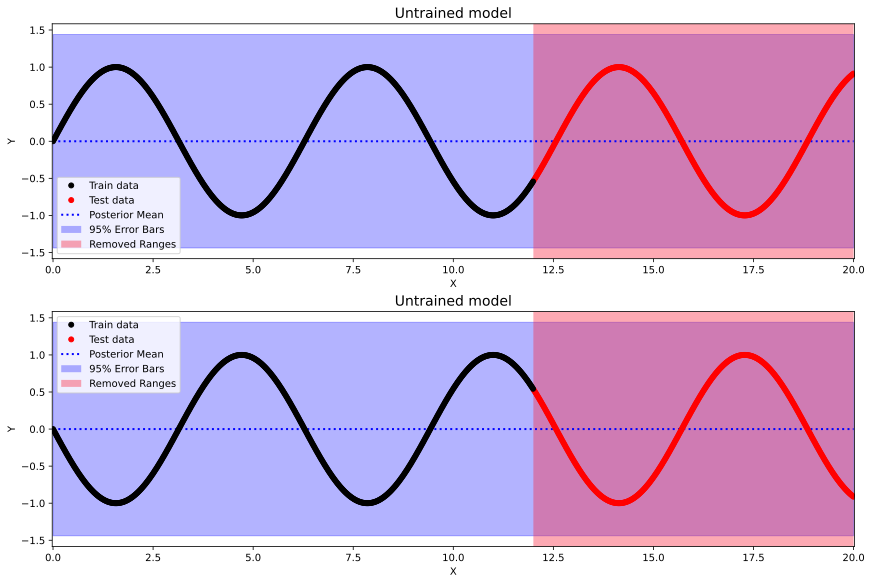

In [ ]:
# plot the prediction with the untrained model
model.plot_prediction(title='Untrained model');

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 2
‣ Parameters: 22
‣ Training points: 1200
‣ Iterations: 50
   0/50   0:00:02  loss=    -312.719  error=   0.0135963
   4/50   0:00:10  loss=    -313.159  error=    0.016298
   8/50   0:00:20  loss=    -323.479  error=   0.0306671
  16/50   0:00:30  loss=    -345.154  error=  0.00732082
  27/50   0:00:40  loss=    -374.901  error=   0.0093737
  38/50   0:00:50  loss=    -401.597  error=   0.0158103
  50/50   0:01:01  loss=    -428.199  error=   0.0125097
Optimization finished in 1 minute 1 second


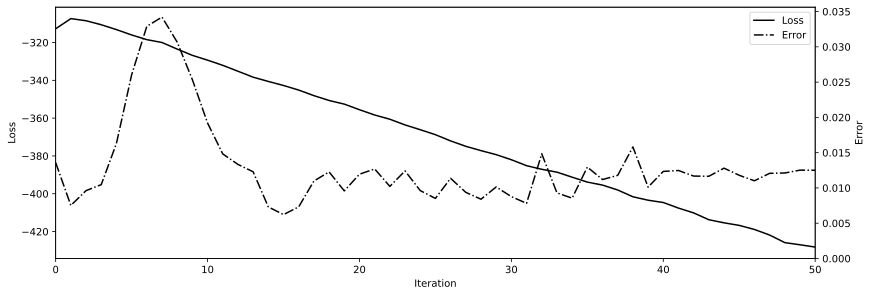

In [ ]:
model.train(method='Adam', lr=0.02, iters=50, plot=True, error='MAE', verbose=True);


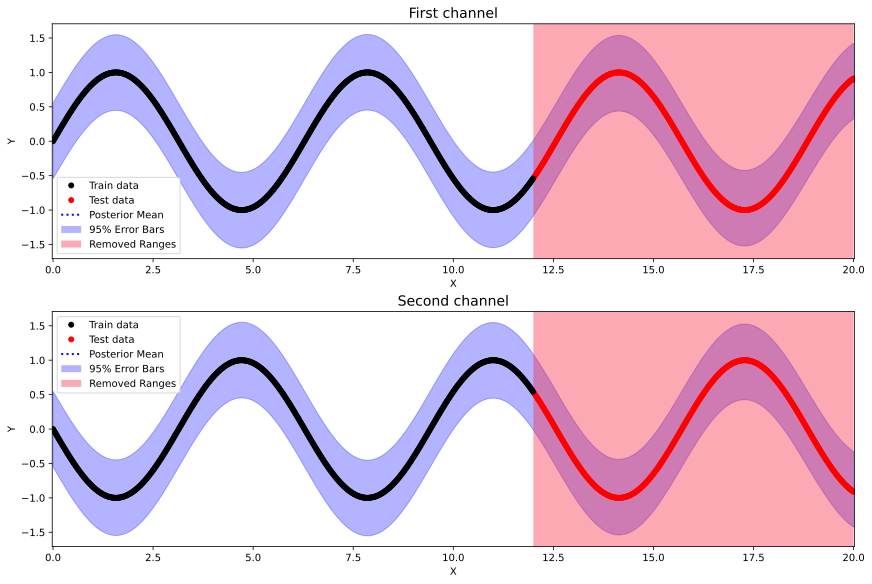

In [ ]:
model.plot_prediction();


### Two Coupled Sinusoids

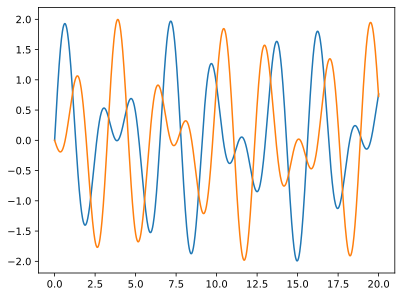

In [ ]:
# Pg. 2: https://scholar.harvard.edu/files/schwartz/files/lecture3-coupled-oscillators.pdf

# Sinusoid definitions
def sin_sum(A_s, A_f, k, kappa, m, t, phi_s, phi_f):
  w_s = np.sqrt(k / m)
  w_f = np.sqrt((k + 2 * kappa) / m)
  return A_s * np.sin(w_s * t + phi_s) + A_f * np.sin(w_f * t + phi_f)

def sin_diff(A_s, A_f, k, kappa, m, t, phi_s, phi_f):
  w_s = np.sqrt(k / m)
  w_f = np.sqrt((k + 2 * kappa) / m)
  return A_s * np.sin(w_s * t + phi_s) - A_f * np.sin(w_f * t + phi_f)

# Sinusoidal params
A_s = 1
A_f = 1
k = 4
kappa = 2
m = 1
phi_s = 0
phi_f = 0

# Sampling params
n_obs = 1000
x_min = 0
x_max = 20

# Sample
x = np.linspace(x_min, x_max, n_obs)

# Apply
y_sum = sin_sum(A_s, A_f, k, kappa, m, x, phi_s, phi_f)
y_diff = sin_diff(A_s, A_f, k, kappa, m, x, phi_s, phi_f)

plt.plot(x, y_sum)
plt.plot(x, y_diff)


In [ ]:
# create dataset
coupled_dataset = mogptk.DataSet(
    mogptk.Data(x, y_sum, name='First channel'),
    mogptk.Data(x, y_diff, name='Second channel'),
)

# remove a future set of data from each sinusoid
coupled_dataset[0].remove_range(start = 12.0)
coupled_dataset[1].remove_range(start = 12.0)

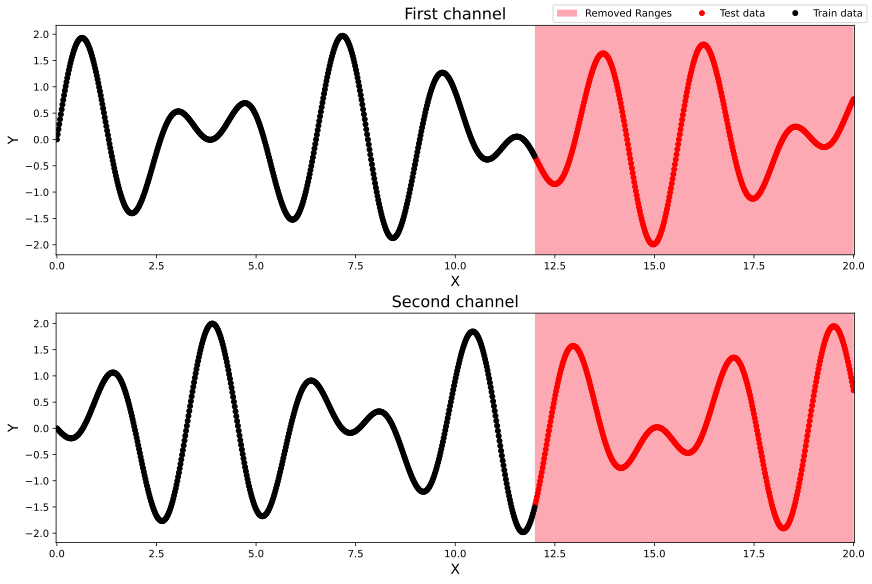

In [ ]:
coupled_dataset.plot();

In [ ]:
# create model, uncomment for different kernels
coupled_model = mogptk.MOSM(coupled_dataset, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SM_LMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
coupled_model.init_parameters(method='LS', iters=500)

In [ ]:
coupled_model.train(method='Adam', lr=0.02, iters=50, plot=True, error='MAE', verbose=True);


In [ ]:
coupled_model.print_parameters()

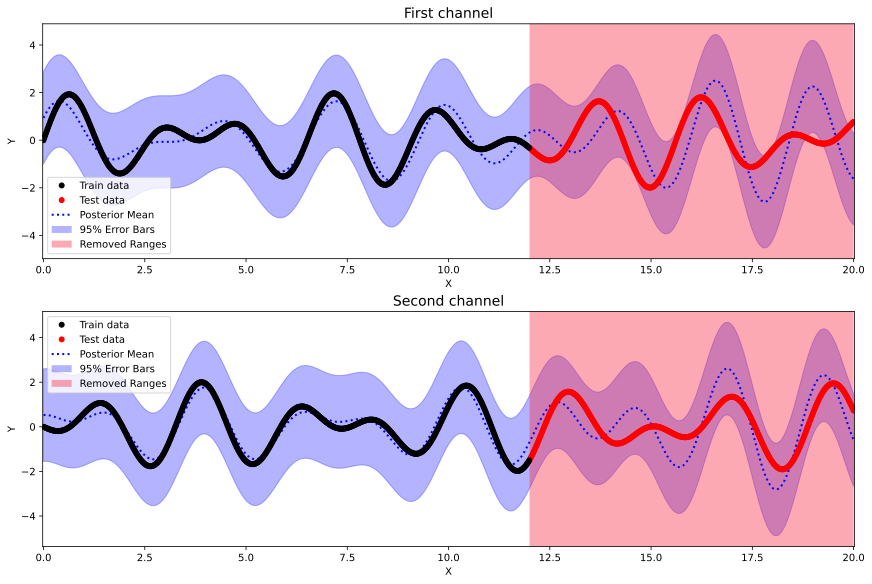

In [ ]:
coupled_model.plot_prediction();


### Four Antagonistic Sinusoids

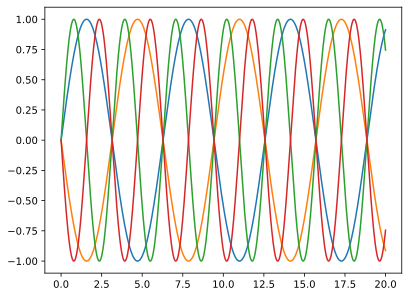

In [ ]:
t = np.linspace(0, 20, 1000)
t_2d = np.array([t, t])
y1 = np.sin(t)
y2 = -np.sin(t)
y3 = np.sin(2*t)
y4 = -np.sin(2*t)
# y5 = 2 * np.sin(0.5 * t)
# y6 = -2 * np.sin(0.5 * t)
# y5 = np.sin(t + 2)
# y6 = -np.sin(t + 2)
# y7 = np.sin(2*t + 2)
# y8 = -np.sin(2*t + 2)
y = np.array([y1, y2, y3, y4])

plt.plot(t, y1)
plt.plot(t, y2)
plt.plot(t, y3)
plt.plot(t, y4)

In [ ]:
# create dataset
dataset_4sin = mogptk.DataSet(
    mogptk.Data(t, y1, name='First channel'),
    mogptk.Data(t, y2, name='Second channel'),
    mogptk.Data(t, y3, name='Third channel'),
    mogptk.Data(t, y4, name='Fourth channel'),
)

# remove a future set of data from each sinusoid
dataset_4sin[0].remove_range(start = 12.0)
dataset_4sin[1].remove_range(start = 12.0)
dataset_4sin[2].remove_range(start = 12.0)
dataset_4sin[3].remove_range(start = 12.0)

(<Figure size 1200x1600 with 4 Axes>,
 array([[<Axes: title={'center': 'First channel'}, xlabel='X', ylabel='Y'>],
        [<Axes: title={'center': 'Second channel'}, xlabel='X', ylabel='Y'>],
        [<Axes: title={'center': 'Third channel'}, xlabel='X', ylabel='Y'>],
        [<Axes: title={'center': 'Fourth channel'}, xlabel='X', ylabel='Y'>]],
       dtype=object))

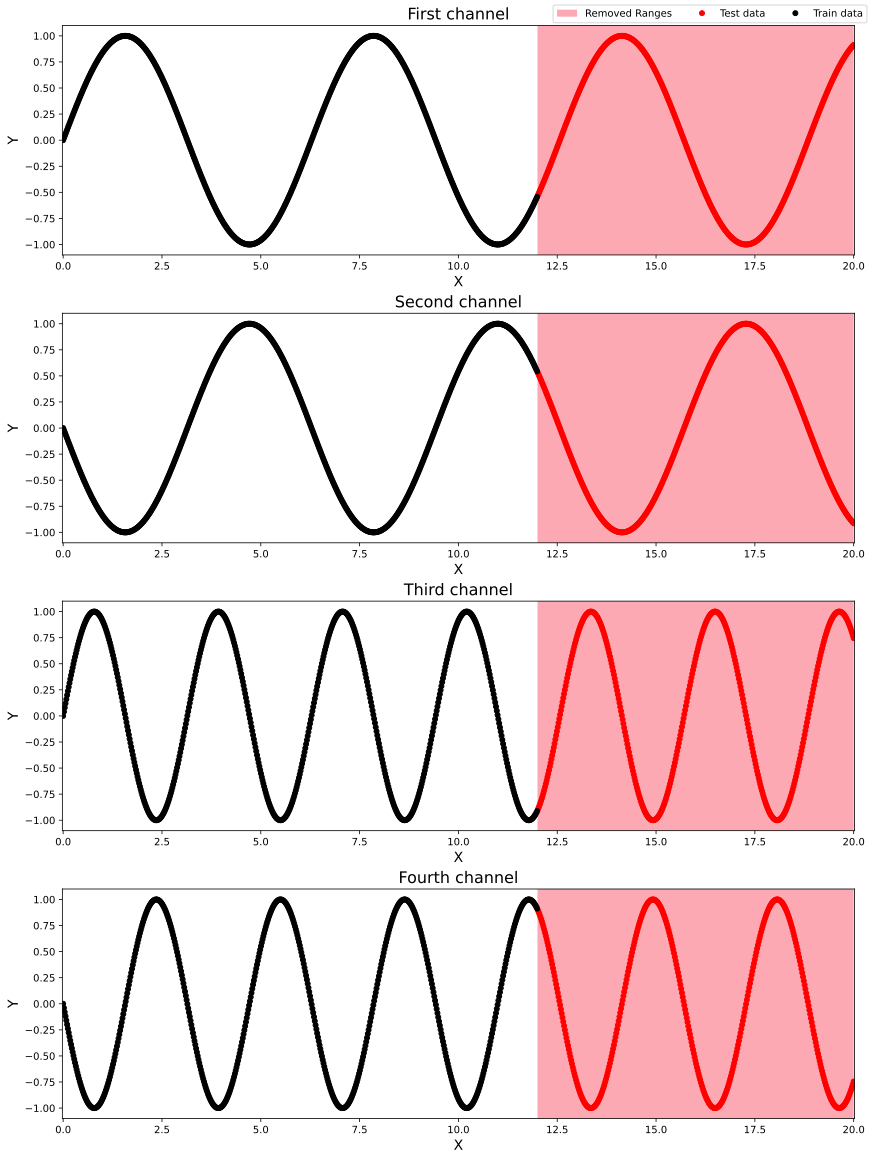

In [ ]:
dataset_4sin.plot()

In [ ]:
# create model, uncomment for different kernels
model_4sin = mogptk.MOSM(dataset_4sin, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SM_LMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model_4sin.init_parameters(method='LS', iters=500)

In [ ]:
model_4sin.print_parameters()

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 44
‣ Training points: 2400
‣ Iterations: 50
   0/50   0:00:11  loss=     2644.08  error=    0.617084
   2/50   0:00:25  loss=     1571.59  error=     0.61619
   3/50   0:00:32  loss=     1488.97  error=    0.329912
   5/50   0:00:47  loss=     1474.75  error=    0.226721
   6/50   0:00:53  loss=     1471.29  error=    0.237824
   7/50   0:01:01  loss=     1467.83  error=    0.258976
   9/50   0:01:15  loss=     1460.39  error=    0.300855
  10/50   0:01:22  loss=     1456.34  error=    0.317697
  12/50   0:01:36  loss=     1447.59  error=    0.341228
  13/50   0:01:43  loss=     1442.92  error=    0.347362
  14/50   0:01:51  loss=     1438.08  error=    0.349592
  16/50   0:02:04  loss=     1428.04  error=    0.343181
  17/50   0:02:11  loss=     1422.91  error=    0.335364
  19/50   0:02:25  loss=     1412.56  error=    0.312844
  

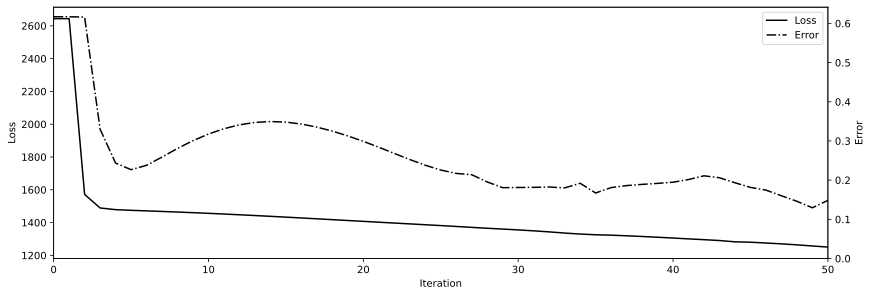

In [ ]:
model_4sin.train(method='Adam', lr=0.02, iters=50, plot=True, error='MAE', verbose=True);


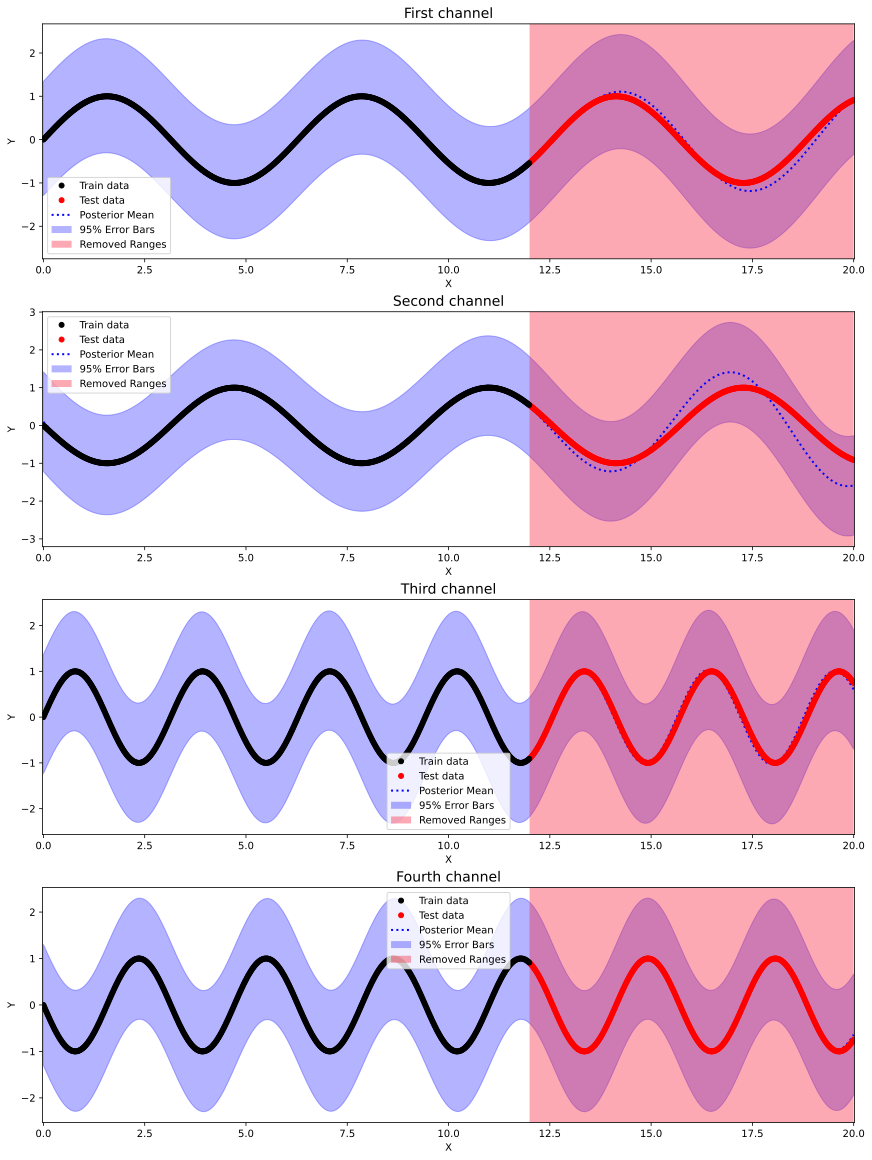

In [ ]:
model_4sin.plot_prediction();


### Eight Antagonistic Sinusoids

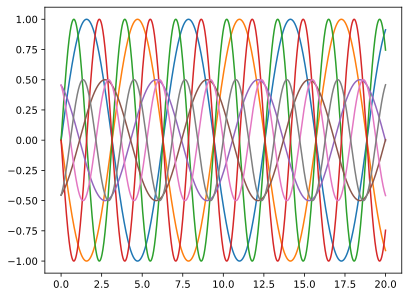

In [ ]:
t = np.linspace(0, 20, 5000)
t_2d = np.array([t, t])
y1 = np.sin(t)
y2 = -np.sin(t)
y3 = np.sin(2*t)
y4 = -np.sin(2*t)
y5 = 2 * np.sin(0.5 * t)
y6 = -2 * np.sin(0.5 * t)
y5 = 0.5 * np.sin(t + 2)
y6 = -0.5 *  np.sin(t + 2)
y7 = 0.5 * np.sin(2*t + 2)
y8 = -0.5 * np.sin(2*t + 2)
y = np.array([y1, y2, y3, y4, y5, y6, y7, y8])

plt.plot(t, y1)
plt.plot(t, y2)
plt.plot(t, y3)
plt.plot(t, y4)
plt.plot(t, y5)
plt.plot(t, y6)
plt.plot(t, y7)
plt.plot(t, y8)

In [ ]:
# create dataset
dataset_8sin = mogptk.DataSet(
    mogptk.Data(t, y1, name='First channel'),
    mogptk.Data(t, y2, name='Second channel'),
    mogptk.Data(t, y3, name='Third channel'),
    mogptk.Data(t, y4, name='Fourth channel'),
    mogptk.Data(t, y5, name='Fifth channel'),
    mogptk.Data(t, y6, name='Sixth channel'),
    mogptk.Data(t, y7, name='Seventh channel'),
    mogptk.Data(t, y8, name='Eighth channel'),
)

# remove a future set of data from each sinusoid
dataset_8sin[0].remove_range(start = 12.0)
dataset_8sin[1].remove_range(start = 12.0)
dataset_8sin[2].remove_range(start = 12.0)
dataset_8sin[3].remove_range(start = 12.0)
dataset_8sin[4].remove_range(start = 10.0)
dataset_8sin[5].remove_range(start = 10.0)
dataset_8sin[6].remove_range(start = 10.0)
dataset_8sin[7].remove_range(start = 10.0)

# create model, uncomment for different kernels
model_8sin = mogptk.MOSM(dataset_8sin, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SM_LMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model_8sin.init_parameters(method='LS', iters=500)

model_8sin.train(method='Adam', lr=0.02, iters=50, plot=True, error='MAE', verbose=True);


Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 8
‣ Parameters: 88
‣ Training points: 22000
‣ Iterations: 50


In [ ]:
model_8sin.plot_prediction();
# Failed when N = 10,000

## GPY with Multiple Outputs

In [ ]:
!pip install pods

In [ ]:
## Example from: https://github.com/SheffieldML/notebook/blob/master/GPy/multiple%20outputs.ipynb
# import pods

# data = pods.datasets.olympic_sprints()
# Xoly = data['X']
# yoly = data['Y']
# print(f"{data['info']}, {data['details']}")

Olympics sprint event winning for men and women to 2008. Data is from Rogers and Girolami's First Course in Machine Learning., Data from the textbook 'A First Course in Machine Learning'. Available from http://www.dcs.gla.ac.uk/~srogers/firstcourseml/.


In [ ]:
yoly.shape

NameError: name 'yoly' is not defined

In [ ]:
X.shape

(126, 2)

In [ ]:
y.shape

(126, 1)

In [ ]:
t = np.linspace(0, 20, 100)
t_stacked = np.concatenate([t, t], axis=0)
idx = np.array([1] * 1000 + [2] * 1000)
X = np.array([t_stacked, idx]).T
y1 = np.sin(t)
y2 = -np.sin(t)
y = np.concatenate([y1, y2], axis=0).reshape(-1, 1)
# Y = np.array([y, idx]).T

plt.plot(t, y1)
plt.plot(t, y2)

plt.plot(t, y1)
plt.plot(t, y2)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
X.shape

(2000, 2)

In [ ]:
y.shape

(2000, 1)

In [ ]:
Y[:, :10]

NameError: name 'Y' is not defined

In [ ]:
X.shape

(2000, 2)

In [ ]:
kern = GPy.kern.RBF(1) ** GPy.kern.Coregionalize(1, output_dim=2, rank=1)
display(kern)

In [ ]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

In [ ]:
fig, ax = plt.subplots()
for i in range(2):
    model.plot(fignum = 1,
               fixed_inputs = [(1, i)],
               ax = ax,
               legend = i == 0)
# plt.xlabel('Time')
# plt.ylabel('Response')

## TSGM Simulated Data

[TSGM Docs](https://tsgm.readthedocs.io/en/latest/)

### TSGM - Install and Import

In [ ]:
!pip install -U tsgm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tsgm

### Test Generating UCR Data on TSGM

In [ ]:
ucr_manager = tsgm.utils.UCRDataManager(ds="ECG200")
X_train, y_train, X_test, y_test = ucr_manager.get()
print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)
print("Unique Labels: ", set(list(y_train) + list(y_test)))

Train Data:  (100, 96) (100,)
Test Data:  (100, 96) (100,)
Unique Labels:  {1, -1}


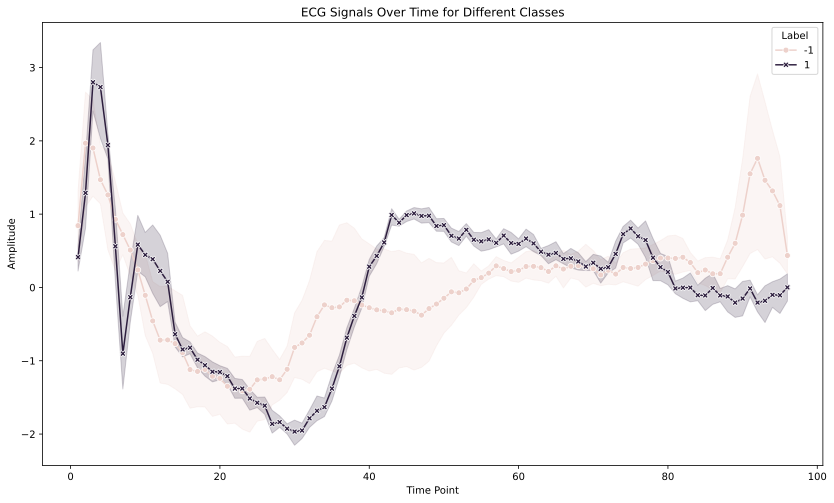

In [ ]:
df = pd.DataFrame(X_train, columns=[f'Time_{i+1}' for i in range(X_train.shape[1])])
df['Label'] = y_train

# Sample a few signals from each class to plot (5 samples per class)
sampled_df = df.groupby('Label').apply(lambda x: x.sample(5)).reset_index(drop=True)

melted_df = sampled_df.melt(id_vars='Label', var_name='Time', value_name='Amplitude')
melted_df['Time'] = melted_df['Time'].str.replace('Time_', '').astype(int)

# Plot the line plots
plt.figure(figsize=(14, 8))
sns.lineplot(data=melted_df, x='Time', y='Amplitude', hue='Label', style='Label', markers=True, dashes=False)
plt.title('ECG Signals Over Time for Different Classes')
plt.xlabel('Time Point')
plt.ylabel('Amplitude')
plt.show()

### TSGM for Sinusoidal Data

Below is a good and easy module to generate sinusoids compared to our manual effort in the MOGPTK section. However we want to look for more realistic data to fit into a Gaussian Process and NCDE framework.

In [ ]:
# N = # of samples in the dataset
# T = length of each time series in the dataset
# D = # of dimensions (sinusoids) in each time series
# max_value = maximum value for amplitude and shift of the sinusoids. Defaults to 10
sine_tgsm_data = tsgm.utils.gen_sine_dataset(N = 10000,
                                             T = 24,
                                             D = 5)

scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_sine_tsgm_data = scaler.fit_transform(sine_tgsm_data)

In [ ]:
ssd_1st_dim = pd.DataFrame(scaled_sine_tsgm_data[:, :, 0])



0         1         2         3         4         5         6   \
0  0.528170  0.516678  0.504755  0.492707  0.480840  0.469458  0.458853   
1  0.993900  0.983317  0.960382  0.925682  0.880104  0.824811  0.761217   
2  0.530713  0.516820  0.502492  0.488096  0.474000  0.460564  0.448130   
3  0.549467  0.479580  0.410210  0.343130  0.280053  0.222589  0.172209   
4  0.517241  0.476467  0.436290  0.397735  0.361789  0.329369  0.301304   

         7         8         9   ...        14        15        16        17  \
0  0.449293  0.441025  0.434259  ...  0.427451  0.431739  0.437766  0.445378   
1  0.690945  0.615791  0.537675  ...  0.172288  0.117385  0.072252  0.038041   
2  0.437018  0.427510  0.419849  ...  0.414212  0.419820  0.427473  0.436974   
3  0.130197  0.097627  0.075332  ...  0.128105  0.169612  0.219555  0.276657   
4  0.278310  0.260974  0.249740  ...  0.289391  0.315060  0.345449  0.379781   

         18        19        20        21        22        23  
0  0.454381  0.464546  0.475611  0.487295  0.499300  0.511318  
1  0.015627  0.005582  0.008163  0.023304  0.050617  0.089406  
2  0.448080  0.460508  0.473941  0.488035  0.502430  0.516759  
3  0.339460  0.406360  0.475647  0.545553  0.614290  0.680103  
4  0.417180  0.456690  0.497302  0.537979  0.577681  0.615394  

[5 rows x 24 columns]

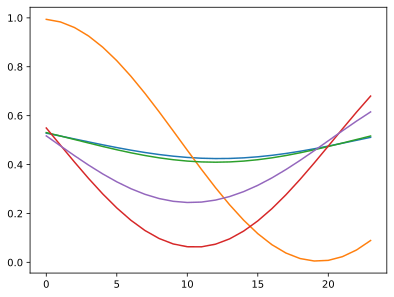

In [ ]:
# N = # of samples in the dataset
# T = length of each time series in the dataset
# D = # of dimensions (sinusoids) in each time series
# max_value = maximum value for amplitude and shift of the sinusoids. Defaults to 10
sine_tgsm_data = tsgm.utils.gen_sine_dataset(N = 10000,
                                             T = 24,
                                             D = 5)

scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_sine_tsgm_data = scaler.fit_transform(sine_tgsm_data)
# Pick one such sinusoid

for i in ssd_1st_dim.index[:5]:
  ssd_1st_dim.iloc[i, :].plot()

In [ ]:
ssd_1st_dim.head()

0         1         2         3         4         5         6   \
0  0.528170  0.516678  0.504755  0.492707  0.480840  0.469458  0.458853   
1  0.993900  0.983317  0.960382  0.925682  0.880104  0.824811  0.761217   
2  0.530713  0.516820  0.502492  0.488096  0.474000  0.460564  0.448130   
3  0.549467  0.479580  0.410210  0.343130  0.280053  0.222589  0.172209   
4  0.517241  0.476467  0.436290  0.397735  0.361789  0.329369  0.301304   

         7         8         9   ...        14        15        16        17  \
0  0.449293  0.441025  0.434259  ...  0.427451  0.431739  0.437766  0.445378   
1  0.690945  0.615791  0.537675  ...  0.172288  0.117385  0.072252  0.038041   
2  0.437018  0.427510  0.419849  ...  0.414212  0.419820  0.427473  0.436974   
3  0.130197  0.097627  0.075332  ...  0.128105  0.169612  0.219555  0.276657   
4  0.278310  0.260974  0.249740  ...  0.289391  0.315060  0.345449  0.379781   

         18        19        20        21        22        23  
0  0.454381  0.464546  0.475611  0.487295  0.499300  0.511318  
1  0.015627  0.005582  0.008163  0.023304  0.050617  0.089406  
2  0.448080  0.460508  0.473941  0.488035  0.502430  0.516759  
3  0.339460  0.406360  0.475647  0.545553  0.614290  0.680103  
4  0.417180  0.456690  0.497302  0.537979  0.577681  0.615394  

[5 rows x 24 columns]

### TSGM - Lotka-Volterra

Shape: (1000, 2)


<Axes: >

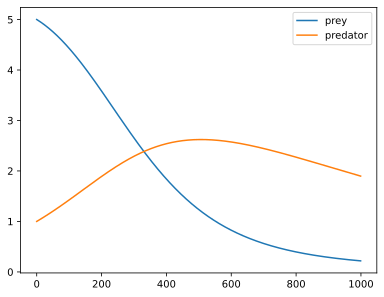

In [ ]:
# Example: https://github.com/AlexanderVNikitin/tsgm/blob/main/tests/test_simulator.py
lv_data = tsgm.dataset.DatasetProperties(N=10, T=40, D=23)


lv_sim = tsgm.simulator.LotkaVolterraSimulator(data = lv_data,
               alpha = 1.2, beta = 2.0, gamma = 1.0, delta = 1.2,
               x0 = 5.0, y0 = 1.0)
# alpha (float): The maximum prey per capita growth rate. Default is 1.
# beta (float): The effect of the presence of predators on the
#               prey death rate. Default is 1.
# gamma (float): The predator’s per capita death rate. Default is 1.
# delta (float): The effect of the presence of prey on the predator’s
#.               growth rate. Default is 1.
# x0 (float): The initial population density of prey.
#             Default is 1.
# y0 (float): The initial population density of predator.
#             Default is 1.
syn_dataset = lv_sim.generate(num_samples = 1000)
syn_df = pd.DataFrame(syn_dataset, columns=['prey', 'predator'])
print(f"Shape: {syn_df.shape}")
syn_df.plot()

In [ ]:
syn_dataset.shape

(100, 2)

In [ ]:
syn_dataset

array([[1.00000000e+00, 5.00000000e+00],
       [9.91229871e-01, 4.99997803e+00],
       [9.82536750e-01, 4.99991236e+00],
       ...,
       [3.09142456e-03, 2.08372313e+00],
       [3.08226178e-03, 2.08164479e+00],
       [3.07313894e-03, 2.07956851e+00]])

In [ ]:
syn_df

0         1
0    1.000000  5.000000
1    0.991230  4.999978
2    0.982537  4.999912
3    0.973920  4.999803
4    0.965379  4.999651
..        ...       ...
995  0.003110  2.087886
996  0.003101  2.085804
997  0.003091  2.083723
998  0.003082  2.081645
999  0.003073  2.079569

[1000 rows x 2 columns]

## Circadian Simulator

In [ ]:
!pip install circadian

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
from circadian.plots import Actogram
from circadian.lights import LightSchedule
from circadian.models import Forger99, Jewett99, Hannay19, Hannay19TP

In [ ]:
days_night = 3
days_day = 2
slam_shift = LightSchedule.ShiftWork(lux=300.0, days_on=days_night, days_off=days_day)

total_days = 30
time = np.arange(0, 24*total_days, 0.10)
light_values = slam_shift(time)

f_model = Forger99()
kj_model = Jewett99()
spm_model = Hannay19()
tpm_model = Hannay19TP()

equilibration_reps = 2
initial_conditions_forger = f_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_kj = kj_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_spm = spm_model.equilibrate(time, light_values, equilibration_reps)
initial_conditions_tpm = tpm_model.equilibrate(time, light_values, equilibration_reps)

In [ ]:
trajectory_f = f_model(time, initial_conditions_forger, light_values)
trajectory_kj = kj_model(time, initial_conditions_kj, light_values)
trajectory_spm = spm_model(time, initial_conditions_spm, light_values)
trajectory_tpm = tpm_model(time, initial_conditions_tpm, light_values)

In [ ]:
dlmo_f = f_model.dlmos()
dlmo_kj = kj_model.dlmos()
dlmo_spm = spm_model.dlmos()
dlmo_tpm = tpm_model.dlmos()

NameError: name 'lines' is not defined

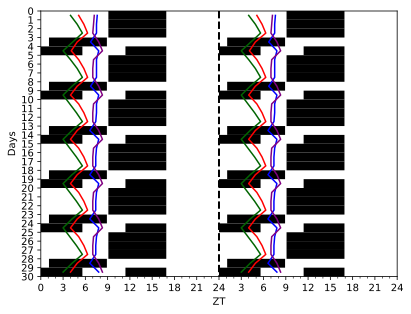

In [ ]:
acto = Actogram(time,
                light_vals=light_values,
                opacity=1.0,
                smooth=False)
acto.plot_phasemarker(dlmo_f, color='blue')
acto.plot_phasemarker(dlmo_spm, color='darkgreen')
acto.plot_phasemarker(dlmo_tpm, color='red')
acto.plot_phasemarker(dlmo_kj, color='purple')

# legend
blue_line = lines.Line2D([], [], color='blue', label='Forger99')
green_line = lines.Line2D([], [], color='darkgreen', label='Hannay19')
red_line = lines.Line2D([], [], color='red', label='Hannay19TP')
purple_line = lines.Line2D([], [], color='purple', label='Jewett99')

plt.legend(handles=[blue_line, purple_line, green_line, red_line],
           loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
plt.title("Actogram for a Simulated Shift Worker", pad=35)
plt.tight_layout()
plt.show()

## Tempo

1. [Paper](https://www.nature.com/articles/s41467-022-34185-w#Sec8)

2. [Github](https://github.com/bauerbach95/tempo/tree/main)